# Computer Vision - Tutorial 3

In this practical session, we will use the `opencv` library to perform thresholding, filtering, mathematical morphology and image segmentation.

In [1]:
%matplotlib inline

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from ipywidgets import interact

plt.rcParams['figure.figsize'] = [12, 8]

from matplotlib.colors import LinearSegmentedColormap

def getRandomColorMap(num_colors, bg_color=1):
    colors = np.random.rand(num_colors, 3) * 0.75
    colors[0, :] = bg_color
    colors = tuple(map(tuple, colors))

    labelColorMap = LinearSegmentedColormap.from_list('labelColorMap', colors, N=num_colors)

    return labelColorMap

def multiplot(lines, rows, images, cmap, title):
    plt.figure(figsize=(20,10))
    for i in np.arange(lines*rows):
        
        plt.subplot(lines, rows, i+1)
        plt.imshow(images[i], cmap=cmap[i])
        plt.title(title[i])
        plt.xticks([])
        plt.yticks([])
        
    plt.show()

## 1. Thresholding

#### Compute and display the histogram of a grayscale image

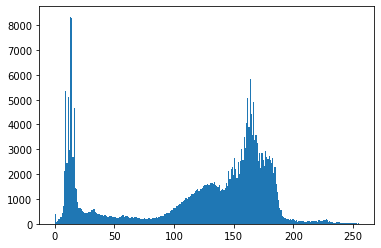

In [2]:
cameraman_gray = cv2.imread('Images/cameraman.jpg', cv2.IMREAD_GRAYSCALE)

hist_np, bins = np.histogram(cameraman_gray.ravel(), 256, [0,256])

hist_cv = cv2.calcHist( [cameraman_gray], [0], None, [256], [0,256])

plt.hist(cameraman_gray.ravel(), bins=256, range=(0,255))
plt.show()

#### Basic thresholding with python

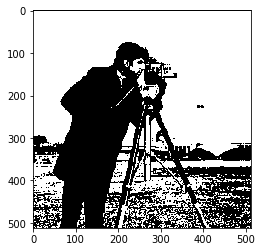

In [3]:
cameraman_threshold = cameraman_gray > 127

plt.imshow(cameraman_threshold, cmap=cm.gray)
plt.show()

#### Thresholding with OpenCV
Determine the v1 and v2 values for the following threshold types:  
cv.THRESH_BINARY
$$\text{th_image}(x,y)=\left\{
                \begin{array}{ll}
                  \texttt{v1} & \text{if img$(x,y)$ > thresh}\\
                  \texttt{v2} & \text{otherwise}
                \end{array}
              \right.
$$

cv.THRESH_BINARY_INV
$$\text{th_image}(x,y)=\left\{
                \begin{array}{ll}
                  \texttt{v1} & \text{if img$(x,y)$ > thresh}\\
                  \texttt{v2} & \text{otherwise}
                \end{array}
              \right.
$$

cv.THRESH_TRUNC
$$\text{th_image}(x,y)=\left\{
                \begin{array}{ll}
                  \texttt{v1} & \text{if img$(x,y)$ > thresh}\\
                  \texttt{v2} & \text{otherwise}
                \end{array}
              \right.
$$

cv.THRESH_TO_ZERO
$$\text{th_image}(x,y)=\left\{
                \begin{array}{ll}
                  \texttt{v1} & \text{if img$(x,y)$ > thresh}\\
                  \texttt{v2} & \text{otherwise}
                \end{array}
              \right.
$$

cv.THRESH_TO_ZERO_INV
$$\text{th_image}(x,y)=\left\{
                \begin{array}{ll}
                  \texttt{v1} & \text{if img$(x,y)$ > thresh}\\
                  \texttt{v2} & \text{otherwise}
                \end{array}
              \right.
$$

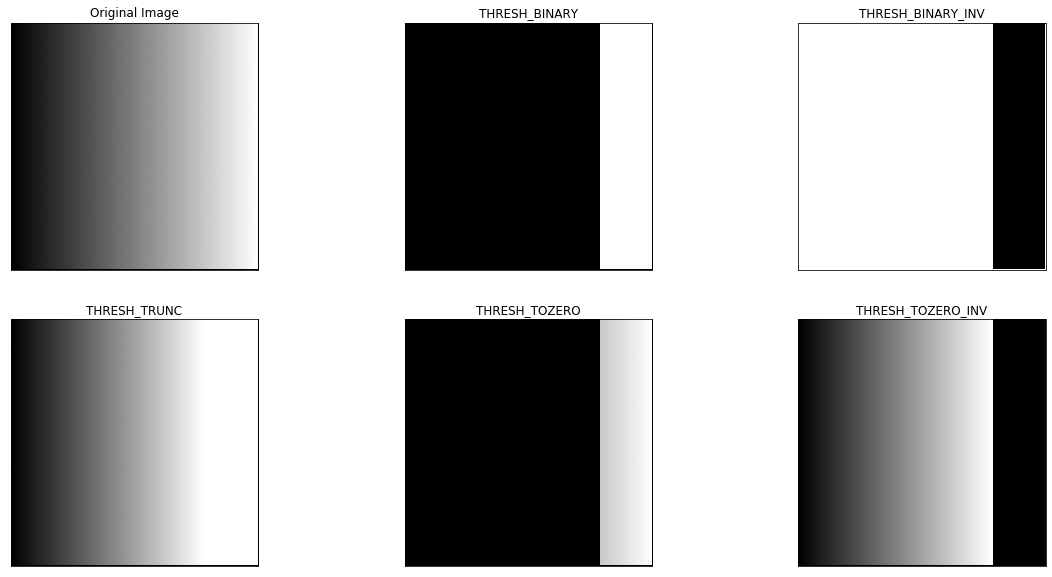

In [4]:
grad = cv2.imread('Images/gradient.png', cv2.IMREAD_GRAYSCALE)

value = 200

ret, thresh1 = cv2.threshold(grad, value, 255, cv2.THRESH_BINARY)
ret, thresh2 = cv2.threshold(grad, value, 255, cv2.THRESH_BINARY_INV)
ret, thresh3 = cv2.threshold(grad, value, 255, cv2.THRESH_TRUNC)
ret, thresh4 = cv2.threshold(grad, value, 255, cv2.THRESH_TOZERO)
ret, thresh5 = cv2.threshold(grad, value, 255, cv2.THRESH_TOZERO_INV)

multiplot(2, 3,
         (grad, thresh1, thresh2, thresh3, thresh4, thresh5),
         (cm.gray, cm.gray, cm.gray, cm.gray, cm.gray, cm.gray),
         ('Original Image', 'THRESH_BINARY', 'THRESH_BINARY_INV',
          'THRESH_TRUNC', 'THRESH_TOZERO', 'THRESH_TOZERO_INV'))

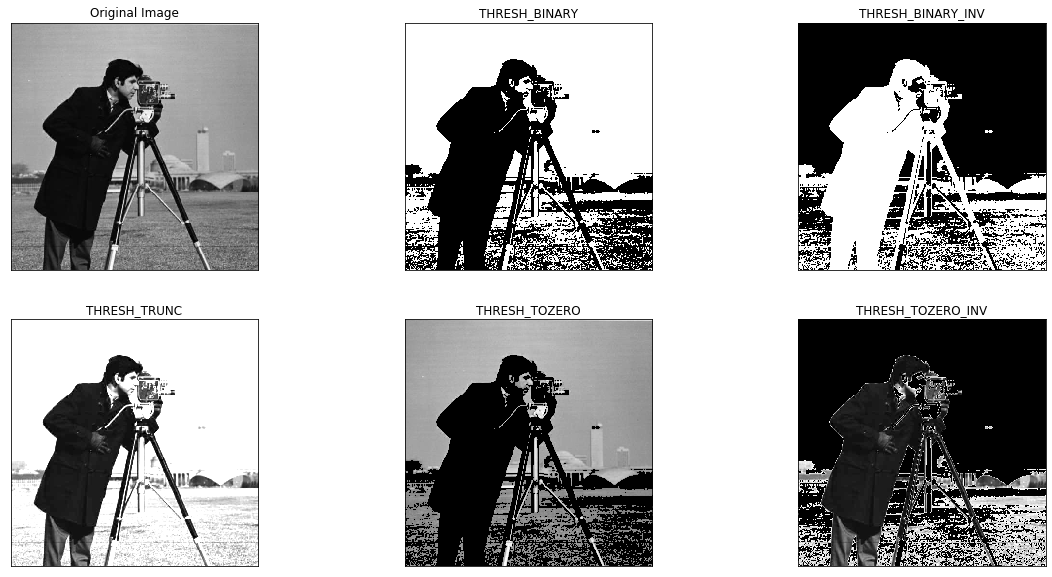

In [5]:
value = 127

ret, thresh1 = cv2.threshold(cameraman_gray, value, 255, cv2.THRESH_BINARY)
ret, thresh2 = cv2.threshold(cameraman_gray, value, 255, cv2.THRESH_BINARY_INV)
ret, thresh3 = cv2.threshold(cameraman_gray, value, 255, cv2.THRESH_TRUNC)
ret, thresh4 = cv2.threshold(cameraman_gray, value, 255, cv2.THRESH_TOZERO)
ret, thresh5 = cv2.threshold(cameraman_gray, value, 255, cv2.THRESH_TOZERO_INV)

multiplot(2, 3,
         (cameraman_gray, thresh1, thresh2, thresh3, thresh4, thresh5),
         (cm.gray, cm.gray, cm.gray, cm.gray, cm.gray, cm.gray),
         ('Original Image', 'THRESH_BINARY', 'THRESH_BINARY_INV',
          'THRESH_TRUNC', 'THRESH_TOZERO', 'THRESH_TOZERO_INV'))

#### Otsu's thresholding
In the previous examples, we had to chose the threshold value. We can use Otsu's algorithm to determine it.

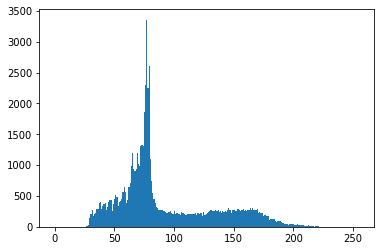

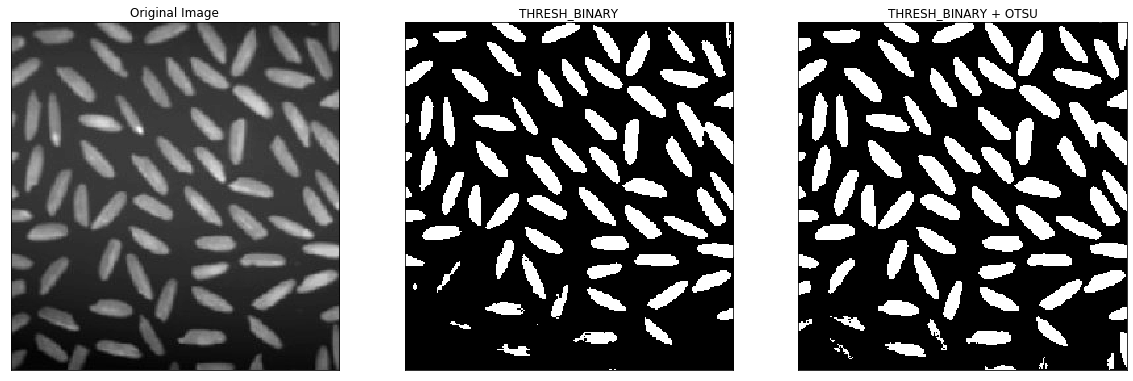

In [6]:
rice = cv2.imread('Images/rice.jpg', cv2.IMREAD_GRAYSCALE)

plt.hist(rice.ravel(), bins=256, range=(0,255))
plt.show()

ret, thresh1 = cv2.threshold(rice, 127, 255, cv2.THRESH_BINARY)

ret, otsu = cv2.threshold(rice, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

multiplot(1, 3,
         (rice, thresh1, otsu),
         (cm.gray, cm.gray, cm.gray),
         ('Original Image', 'THRESH_BINARY', 'THRESH_BINARY + OTSU'))

#### Otsu's algorithm by parts
You can fine-tune the result by applying this algorithm on the different parts of the image.

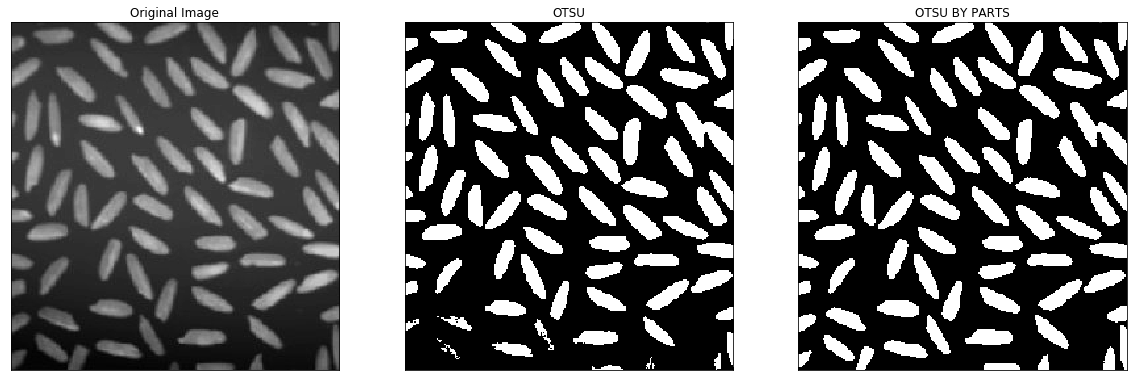

In [7]:
n = 5
h = np.linspace(0, rice.shape[0], n+1).astype('int')
out = []
for i in range(n):
    ret, th = cv2.threshold(rice[h[i]: h[i+1], :], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    out.append(th)

out = np.concatenate(out, axis=0)

multiplot(1, 3,
         (rice, otsu, out),
         (cm.gray, cm.gray, cm.gray),
         ('Original Image', 'OTSU', 'OTSU BY PARTS'))

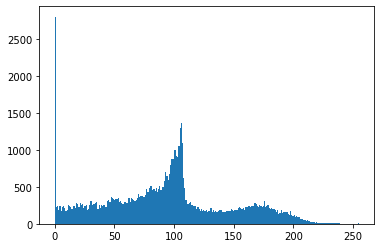

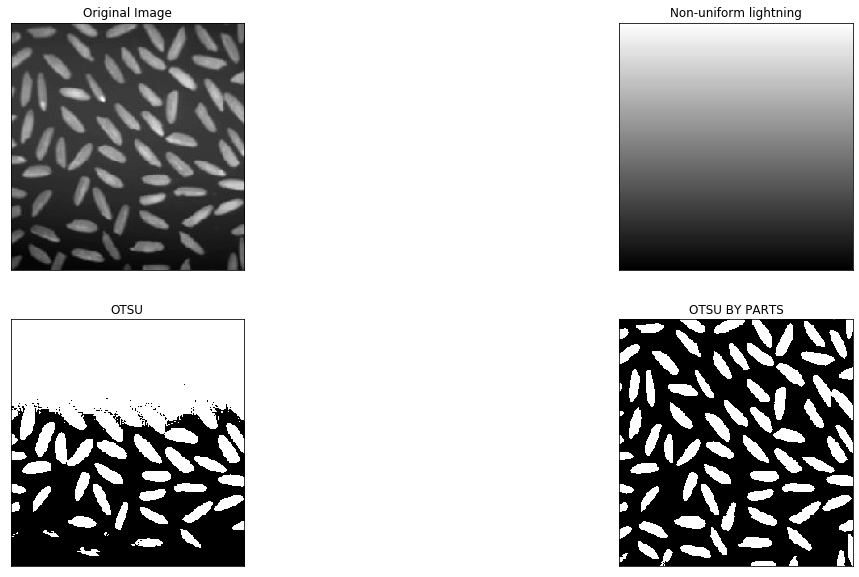

In [8]:
def otsu_parts(img, n, direction):
    
    out = []
    
    if direction == 'horizontal':
        l = img.shape[0]
        h = np.linspace(0, l, n+1).astype('int')
        
        for i in range(n):
            ret, th = cv2.threshold(img[h[i]: h[i+1], :], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            out.append(th)
    else:
        l = img.shape[1]
        h = np.linspace(0, l, n+1).astype('int')
        
        for i in range(n):
            ret, th = cv2.threshold(img[:, h[i]: h[i+1]], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            out.append(th)
    
    
    return np.concatenate(out, axis=0)

light_gradient = np.arange(start=132, stop=-133, step=-1) / 3
non_uniform_lightning = (np.reshape(light_gradient, (265, 1))) * np.ones((1, 250), dtype=int)

img_nu = np.clip(rice+non_uniform_lightning, 0, 255).astype(np.uint8)

plt.hist(img_nu.ravel(), bins=256, range=(0,255))

ret, otsu = cv2.threshold(img_nu, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
otsu_p = otsu_parts(img_nu, 5, 'horizontal')

multiplot(2, 2,
         (rice, non_uniform_lightning, otsu, otsu_p),
         (cm.gray, cm.gray, cm.gray, cm.gray),
         ('Original Image', 'Non-uniform lightning', 'OTSU', 'OTSU BY PARTS'))

## 2. Filtering

#### Gaussian noise

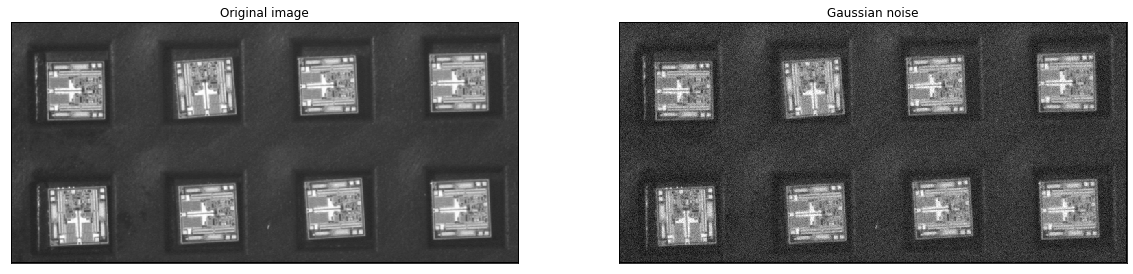

In [9]:
pattern = cv2.imread('Images/Pattern_inspection2.png', cv2.IMREAD_GRAYSCALE)

gaussian_noise = np.zeros_like(pattern, dtype=float)
mean = 0.
std = 10.
cv2.randn(gaussian_noise, mean, std)

pattern_noisy = np.clip(pattern+gaussian_noise, 0, 255).astype(np.uint8)

multiplot(1, 2,
         (pattern, pattern_noisy),
         (cm.gray, cm.gray),
         ('Original image', 'Gaussian noise'))

#### Uniform, Gaussian and bilateral filtering

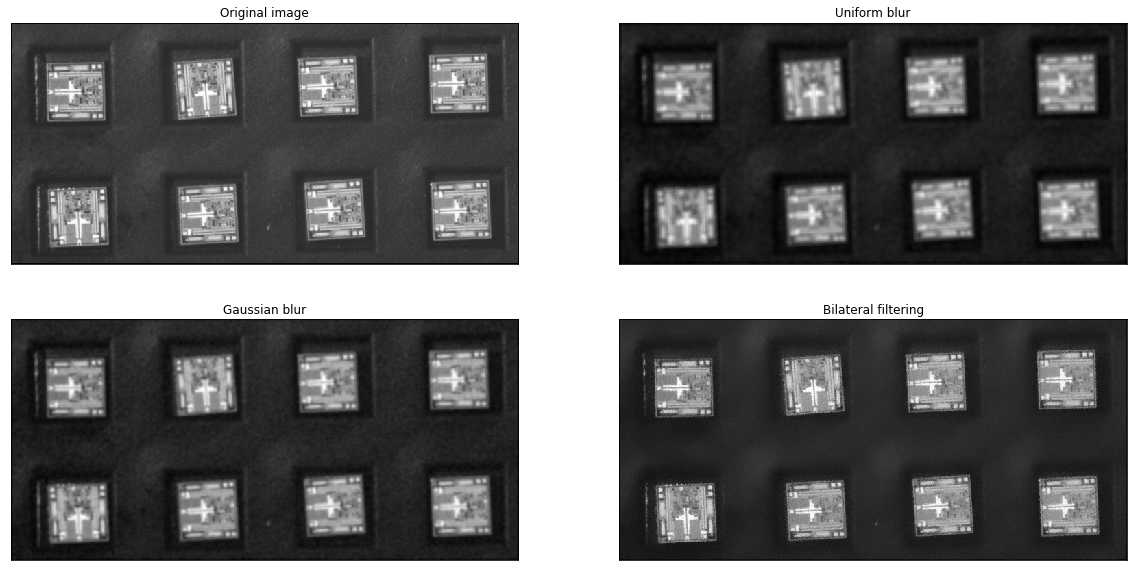

In [10]:
pattern_noisy_uniform_blur = cv2.blur(pattern_noisy, (7, 7))
pattern_noisy_gaussian_blur = cv2.GaussianBlur(pattern_noisy, (7, 7), 0)
pattern_noisy_bilateral = cv2.bilateralFilter(pattern_noisy, -1, 25, 11)

multiplot(2, 2,
         (pattern, pattern_noisy_uniform_blur, pattern_noisy_gaussian_blur, pattern_noisy_bilateral),
         (cm.gray, cm.gray, cm.gray, cm.gray),
         ('Original image', 'Uniform blur', 'Gaussian blur', 'Bilateral filtering'))

#### Salt and pepper noise

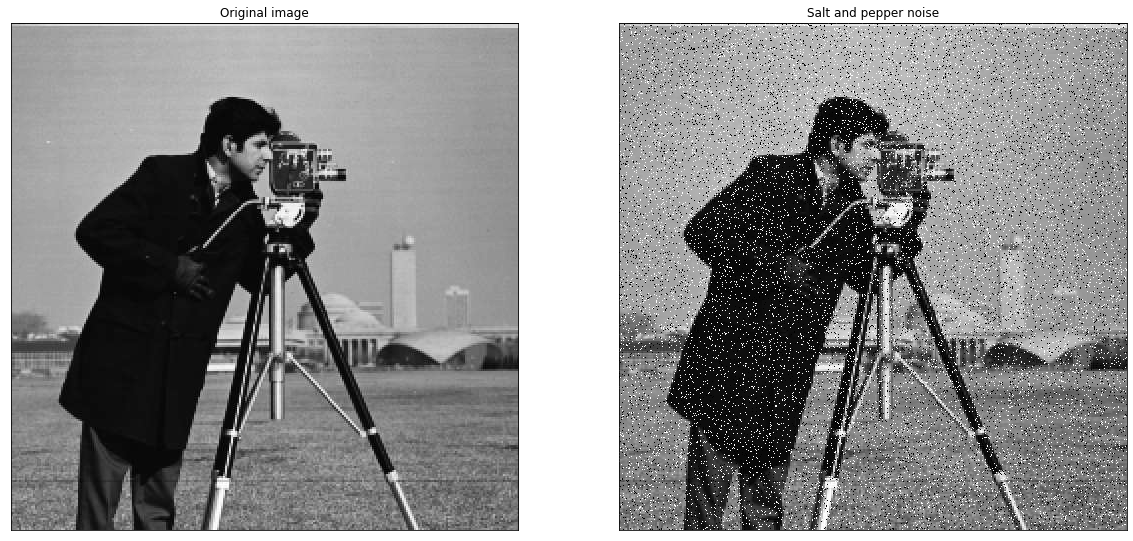

In [11]:
salt_pepper_noise = np.zeros_like(cameraman_gray)
cv2.randu(salt_pepper_noise, 0, 255)
cameraman_noisy = np.where(salt_pepper_noise < 10, 0, np.where(salt_pepper_noise > 240, 255, cameraman_gray))

multiplot(1, 2,
         (cameraman_gray, cameraman_noisy),
         (cm.gray, cm.gray),
         ('Original image', 'Salt and pepper noise'))

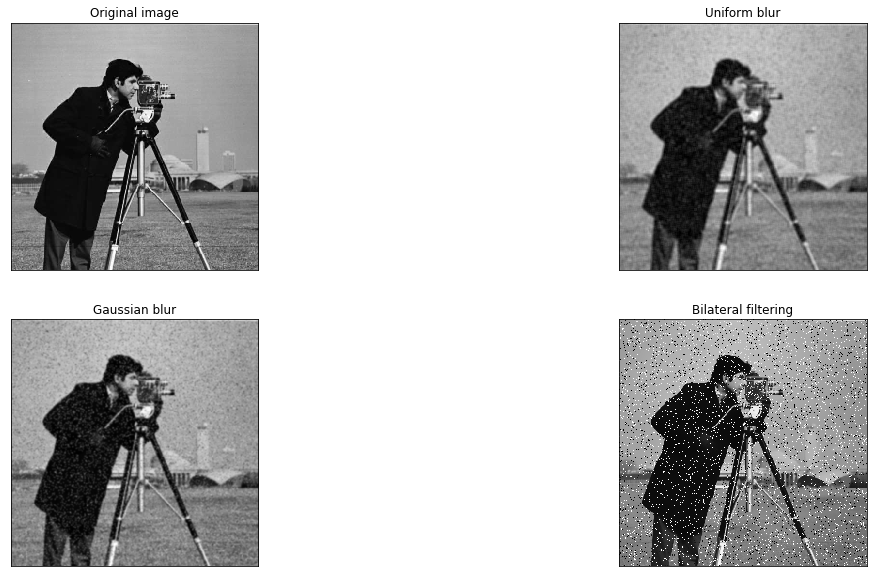

In [12]:
cameraman_noisy_uniform_blur = cv2.blur(cameraman_noisy, (7, 7))
cameraman_noisy_gaussian_blur = cv2.GaussianBlur(cameraman_noisy, (7, 7), 0)
cameraman_noisy_bilateral = cv2.bilateralFilter(cameraman_noisy, -1, 25, 11)

multiplot(2, 2,
         (cameraman_gray, cameraman_noisy_uniform_blur, cameraman_noisy_gaussian_blur, cameraman_noisy_bilateral),
         (cm.gray, cm.gray, cm.gray, cm.gray),
         ('Original image', 'Uniform blur', 'Gaussian blur', 'Bilateral filtering'))

#### Median filtering

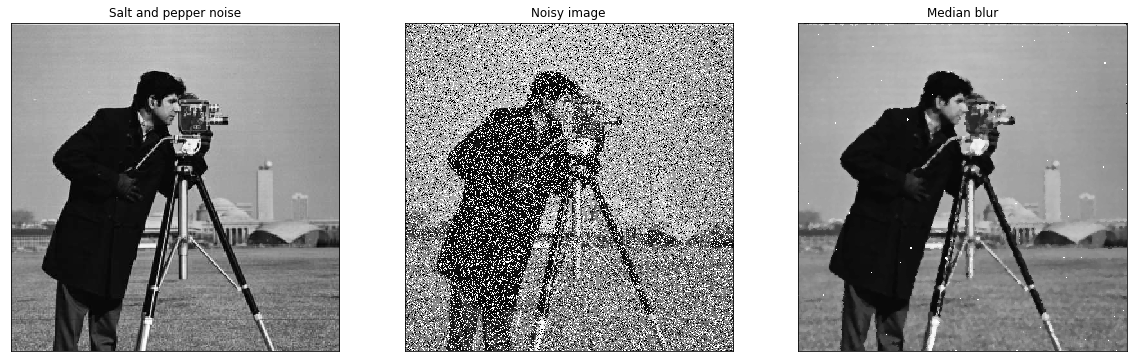

In [13]:
salt_pepper_noise = np.zeros_like(cameraman_gray)
cv2.randu(salt_pepper_noise, 0, 255)
cameraman_noisy = np.where(salt_pepper_noise < 30, 0, np.where(salt_pepper_noise > 200, 255, cameraman_gray))

cameraman_noisy_median = cv2.medianBlur(cameraman_noisy, 5)

multiplot(1, 3,
         (cameraman_gray, cameraman_noisy, cameraman_noisy_median),
         (cm.gray, cm.gray, cm.gray),
         ('Salt and pepper noise', 'Noisy image', 'Median blur'))

## 3. Mathematical morphology

#### Non uniform lightning

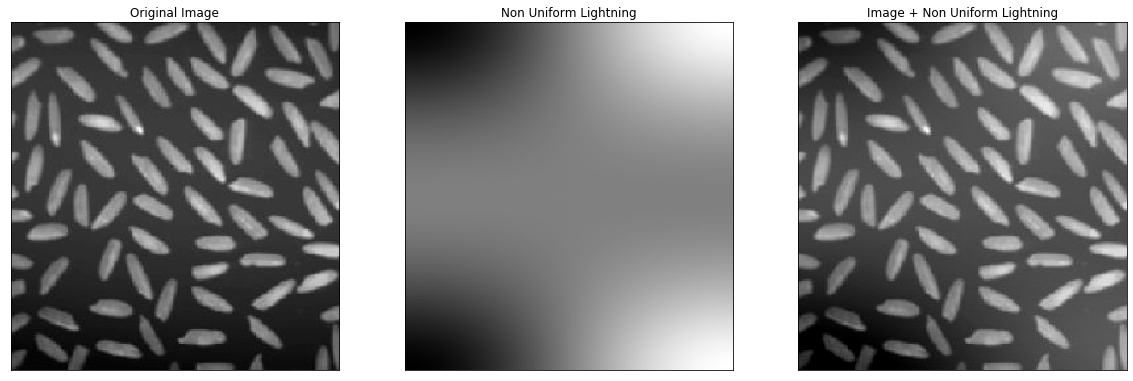

In [14]:
def non_uniform_lightning_like(img, weight):
    width = img.shape[1]
    height = img.shape[0]
    
    steps_y = np.arange( start=0.0, stop=1.0, step=1.0/height)
    light_gradient_y = np.cos( ( 2.0 * ( steps_y * steps_y - steps_y) + 1.0)* np.pi)[:,np.newaxis]

    steps_x = np.arange( start=0.0, stop=1.0, step=1.0/width)
    light_gradient_x = np.cos( steps_x * np.pi)[np.newaxis,:]

    return ( weight * light_gradient_y * light_gradient_x)

nul = non_uniform_lightning_like(rice, 50)
rice_nul = np.clip(rice + nul, 0, 255).astype(np.uint8)

multiplot(1, 3,
         (rice, nul, rice_nul),
         (cm.gray, cm.gray, cm.gray),
         ('Original Image', 'Non Uniform Lightning', 'Image + Non Uniform Lightning'))

#### Erosion and dilation

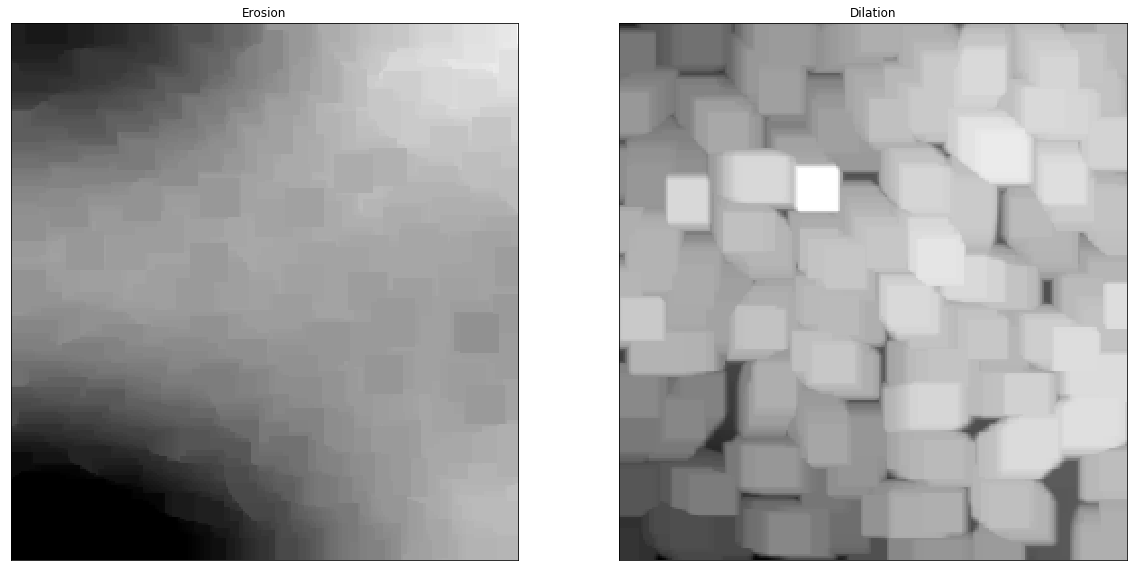

In [15]:
k = 19
kernel = np.ones((k, k))

erd = cv2.erode(rice_nul, kernel, iterations=1)
dlt = cv2.dilate(rice_nul, kernel, iterations=1)

multiplot(1, 2,
         (erd, dlt),
         (cm.gray, cm.gray),
         ('Erosion', 'Dilation'))

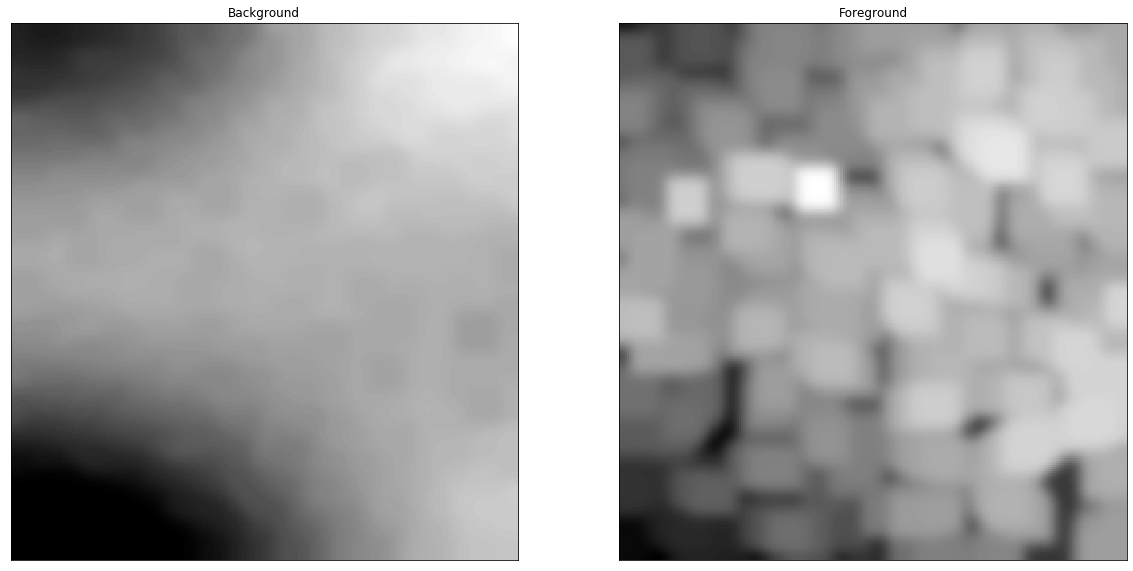

In [16]:
gaussian_erd = cv2.GaussianBlur(erd, (k, k), 0)
gaussian_dlt = cv2.GaussianBlur(dlt, (k, k), 0)

multiplot(1, 2,
         (gaussian_erd, gaussian_dlt),
         (cm.gray, cm.gray),
         ('Background', 'Foreground'))

#### Local adaptation

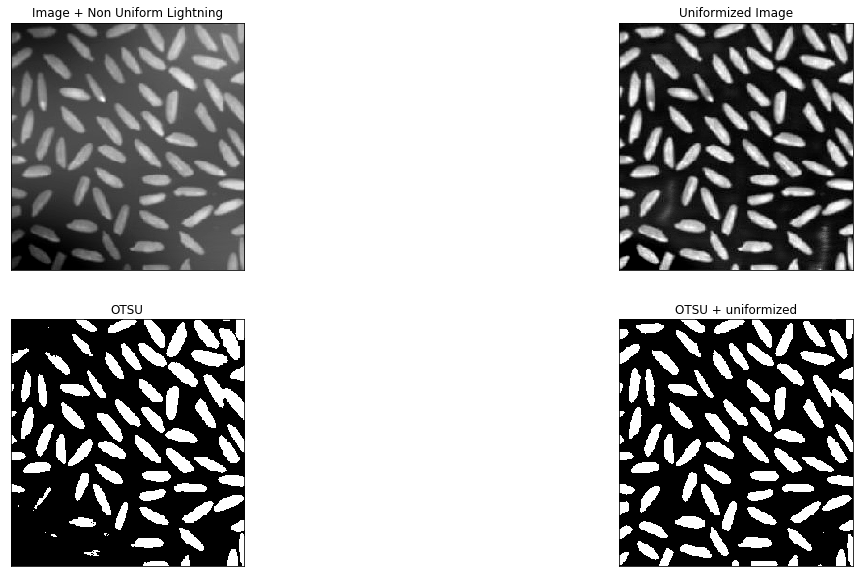

In [17]:
def local_normalize_image(img, k):
    kernel = np.ones((k, k))
    
    erd = cv2.erode(img, kernel, iterations=1)
    dlt = cv2.dilate(img, kernel, iterations=1)
    
    gaussian_erd = cv2.GaussianBlur(erd, (k, k), 0)
    gaussian_dlt = cv2.GaussianBlur(dlt, (k, k), 0)
    
    norm_img = (img - gaussian_erd)/(gaussian_dlt - gaussian_erd + 1) * 255
    
    return np.clip(norm_img, 0, 255).astype(np.uint8)

rice_nul_norm = local_normalize_image(rice_nul, 19)

ret, thresh1 = cv2.threshold(rice_nul, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
ret, thresh2 = cv2.threshold(rice_nul_norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

multiplot(2, 2,
         (rice_nul, rice_nul_norm, thresh1, thresh2),
         (cm.gray, cm.gray, cm.gray, cm.gray),
         ('Image + Non Uniform Lightning', 'Uniformized Image', 'OTSU', 'OTSU + uniformized'))

## 4. Segmentation

#### Thresholding and connected components labelling

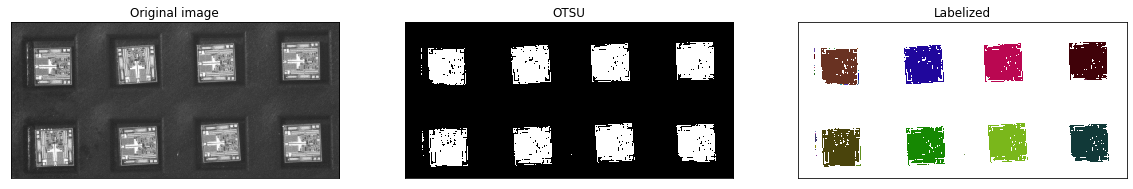

In [18]:
ret, thresh = cv2.threshold(pattern, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

connectivity = 4 #8
conn_comp = cv2.connectedComponentsWithStats(thresh, connectivity, cv2.CV_32S)

num_labels = conn_comp[0]
img_labels = conn_comp[1]

label_colors = getRandomColorMap(num_labels)

multiplot(1, 3,
         (pattern, thresh, img_labels),
         (cm.gray, cm.gray, label_colors),
         ('Original image', 'OTSU', 'Labelized'))

#### Preprocessing
Closing -> Gaussian filtering -> Thresholding -> Connected components labelling

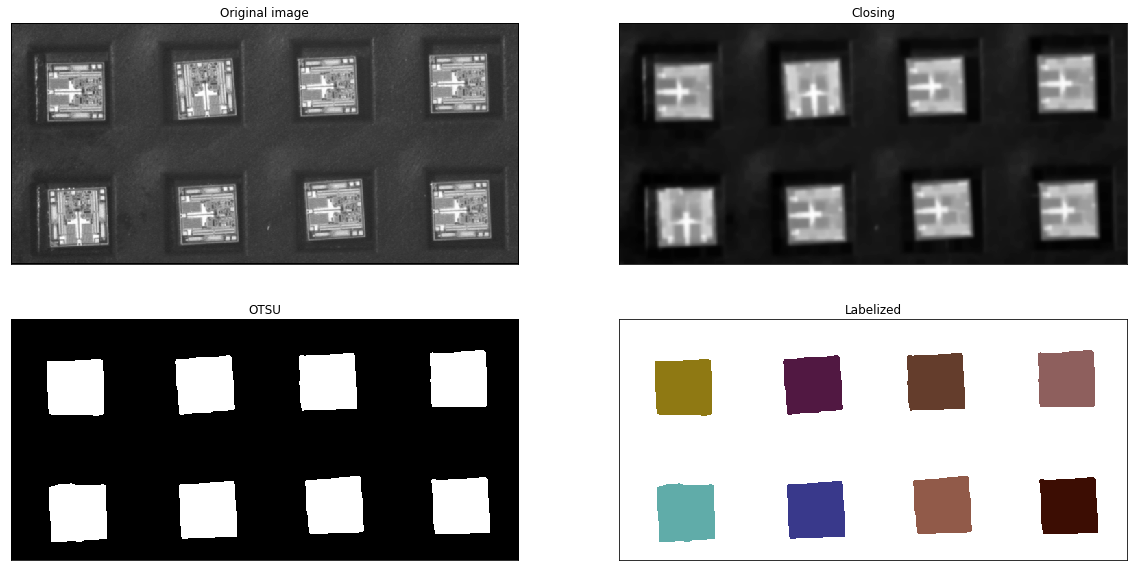

In [19]:
def conn_comp_label_closing(img, k, connectivity=4):
    kernel = np.ones((k, k))
    
    cls = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    
    gaussian_cls = cv2.GaussianBlur(cls, (k, k), 0)
    
    ret, thresh = cv2.threshold(gaussian_cls, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    return cv2.connectedComponentsWithStats(thresh, connectivity, cv2.CV_32S), gaussian_cls, thresh

conn_comp, cls, thresh = conn_comp_label_closing(pattern, 11)

num_labels = conn_comp[0]
img_labels = conn_comp[1]

label_colors = getRandomColorMap(num_labels)

multiplot(2, 2,
         (pattern, cls, thresh, img_labels),
         (cm.gray, cm.gray, cm.gray, label_colors),
         ('Original image', 'Closing', 'OTSU', 'Labelized'))

#### Blob feature

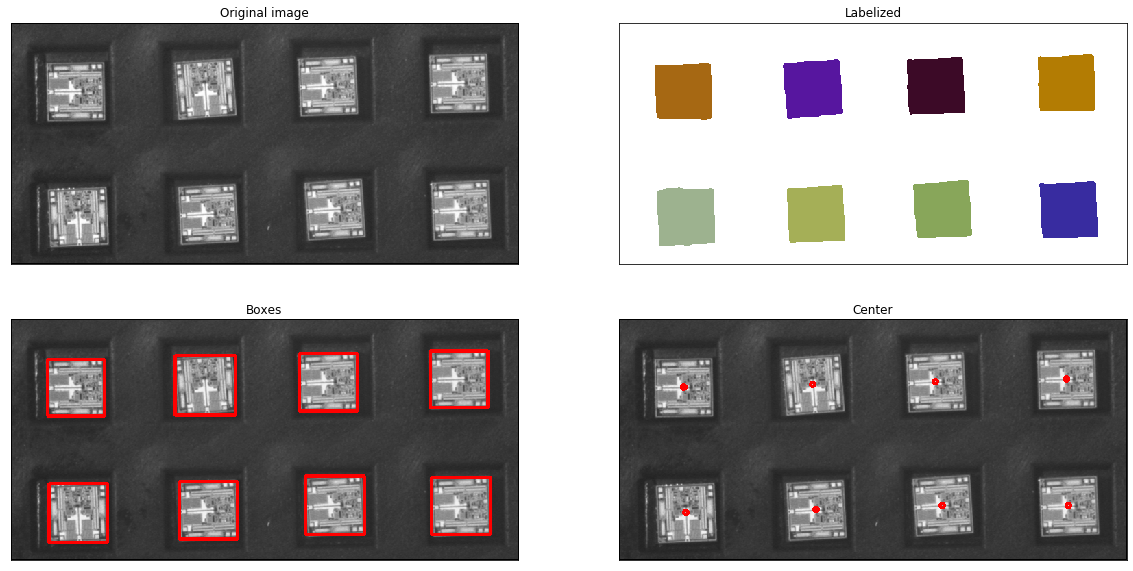

In [20]:
def draw_blob_bounding_boxes(img, conn_comp):
    num_labels = conn_comp[0]
    stats = conn_comp[2]

    img_bb = cv2.cvtColor( img, cv2.COLOR_GRAY2RGB)
    for label in range( 1, num_labels):
        topleft = tuple( stats[label,:2])
        bottomright = tuple( stats[label,:2] + stats[label, 2:4])
        cv2.rectangle( img_bb, topleft, bottomright, (255,0,0), 3)
    
    return img_bb


def draw_blob_centroids(img, conn_comp):
    num_labels = conn_comp[0]
    centroids = conn_comp[3]

    img_ctr = cv2.cvtColor( img, cv2.COLOR_GRAY2RGB)
    for label in range( 1, num_labels):
        centroid = tuple( centroids[label,:].astype(int))
        cv2.circle( img_ctr, centroid, 3, (255,0,0), thickness=3)
    
    return img_ctr

conn_comp, cls, thresh = conn_comp_label_closing(pattern, 11)

num_labels = conn_comp[0]
img_labels = conn_comp[1]

label_colors = getRandomColorMap(num_labels)

pattern_bb = draw_blob_bounding_boxes(pattern, conn_comp)

pattern_ctr = draw_blob_centroids(pattern, conn_comp)

multiplot(2, 2,
         (pattern, img_labels, pattern_bb, pattern_ctr),
         (cm.gray, label_colors, None, None),
         ('Original image', 'Labelized', 'Boxes', 'Center'))

#### Watershed

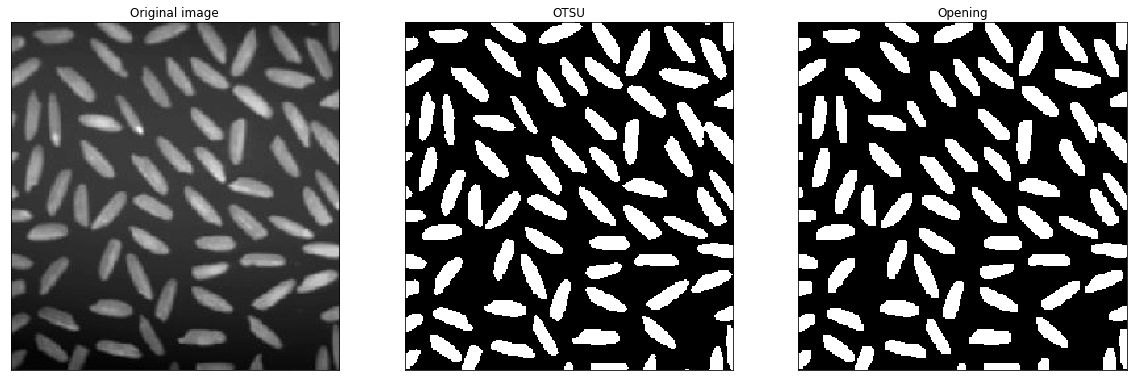

In [21]:
rice_norm = local_normalize_image(rice, 19)

ret, thresh = cv2.threshold(rice_norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

kernel = np.ones((3, 3))
rice_open = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

multiplot(1, 3,
         (rice, thresh, rice_open),
         (cm.gray, cm.gray, cm.gray),
         ('Original image', 'OTSU', 'Opening'))

#### Find sure background

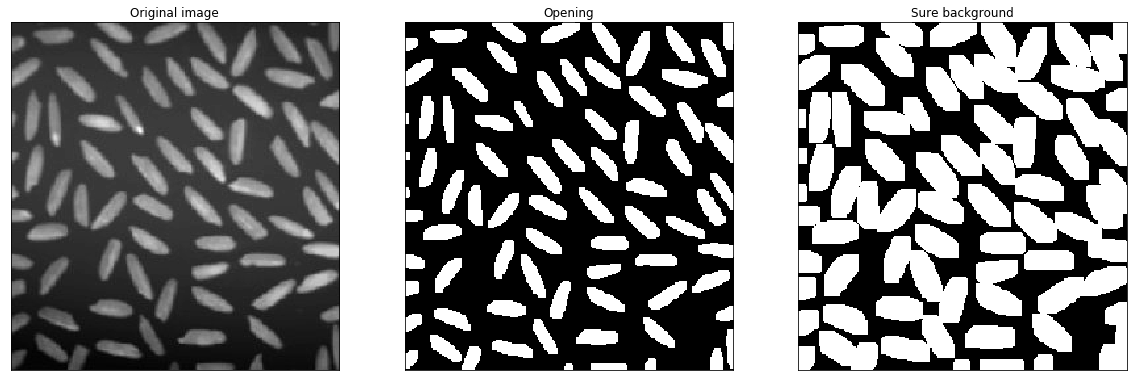

In [22]:
rice_sure_bg = cv2.dilate(rice_open, kernel, iterations=3)

multiplot(1, 3,
         (rice, rice_open, rice_sure_bg),
         (cm.gray, cm.gray, cm.gray),
         ('Original image', 'Opening', 'Sure background'))

#### Find sure foreground

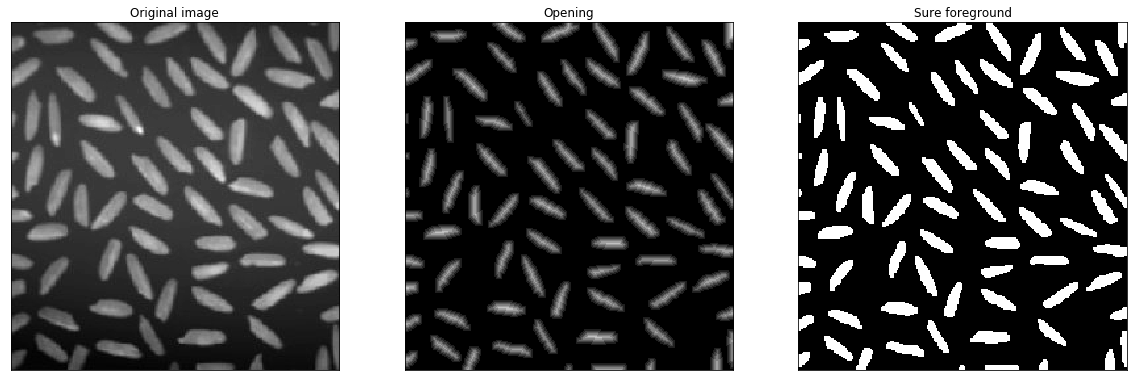

In [23]:
rice_dist_transform = cv2.distanceTransform(rice_open, cv2.DIST_L2, 5).astype(np.uint8)
ret, rice_sure_fg = cv2.threshold(rice_dist_transform, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

multiplot(1, 3,
         (rice, rice_dist_transform, rice_sure_fg),
         (cm.gray, cm.gray, cm.gray),
         ('Original image', 'Opening', 'Sure foreground'))

#### Find unknown region

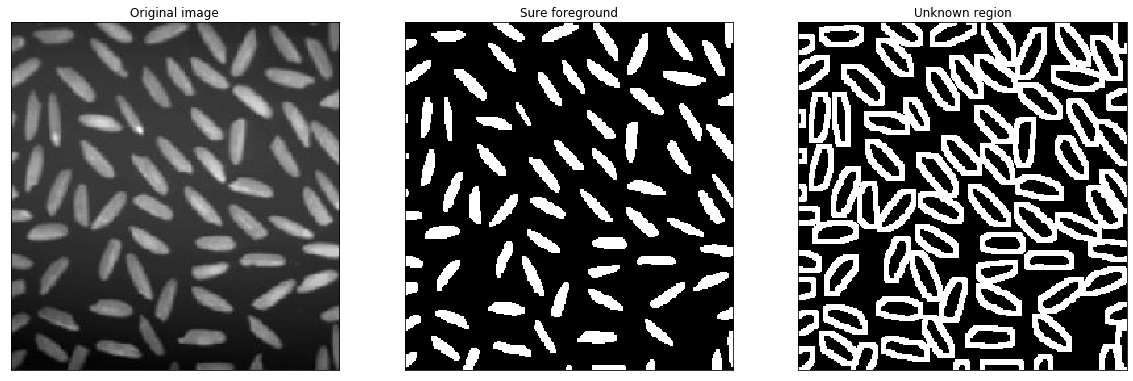

In [24]:
rice_unknown = cv2.subtract(rice_sure_bg, rice_sure_fg)

multiplot(1, 3,
         (rice, rice_sure_fg, rice_unknown),
         (cm.gray, cm.gray, cm.gray),
         ('Original image', 'Sure foreground', 'Unknown region'))

#### Sure labelling of image

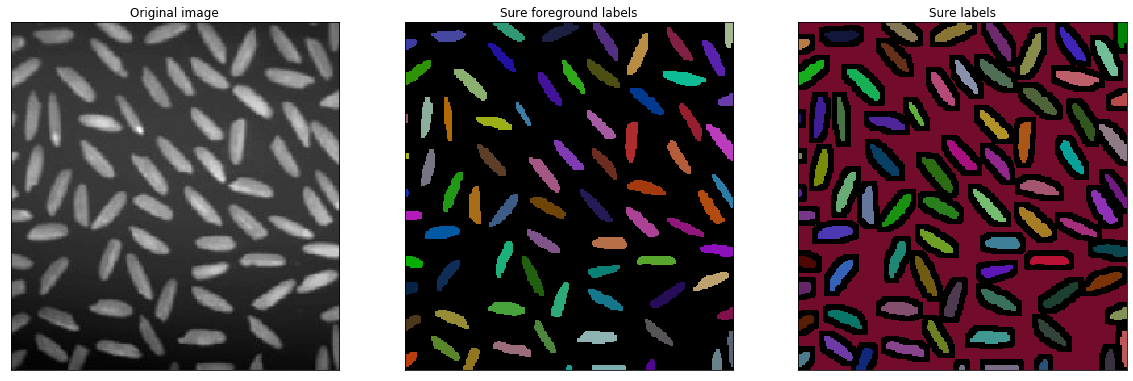

In [25]:
ret, rice_sure_fg_labels = cv2.connectedComponents(rice_sure_fg)

rice_sure_labels = rice_sure_fg_labels + 1

rice_sure_labels[rice_unknown == 255] = 0

num_fg_blobs = rice_sure_fg_labels.max()
label_fg_colors = getRandomColorMap(num_fg_blobs+1, bg_color=0)

num_blobs = rice_sure_labels.max()
label_colors = getRandomColorMap(num_blobs+1, bg_color=0)

multiplot(1, 3, 
         (rice, rice_sure_fg_labels, rice_sure_labels),
         (cm.gray, label_fg_colors, label_colors),
         ('Original image', 'Sure foreground labels', 'Sure labels'))

#### Final segmentation

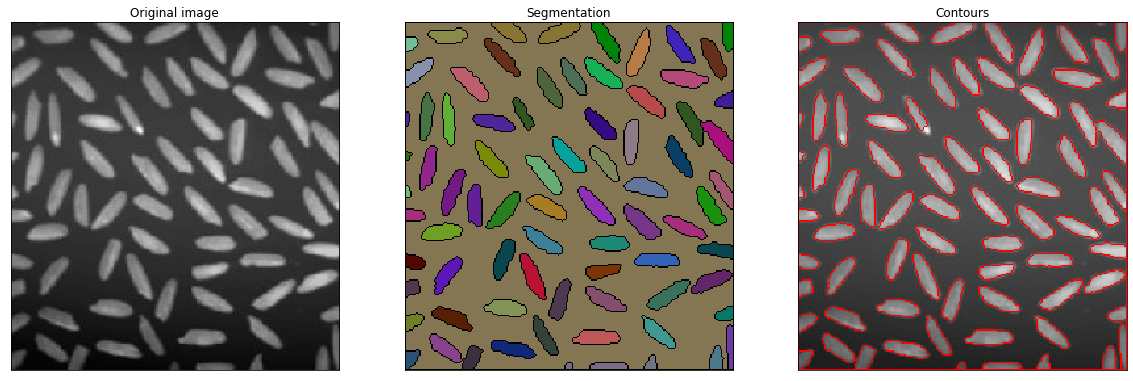

In [26]:
rice_rgb = cv2.cvtColor(rice, cv2.COLOR_BGR2RGB)
rice_labels = cv2.watershed(rice_rgb, rice_sure_labels)

rice_rgb[rice_labels == -1] = [255, 0, 0]

multiplot(1, 3, 
         (rice, rice_labels, rice_rgb),
         (cm.gray, label_colors, None),
         ('Original image', 'Segmentation', 'Contours'))